# Amazon Fine Food Reviews Analysis_Linear Support Vector Machines


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import os

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY TIME DESC LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
1,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ..."
2,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...


In [3]:
filtered_data['Score']

0        1
1        1
2        1
3        1
4        1
        ..
99995    1
99996    1
99997    1
99998    1
99999    1
Name: Score, Length: 100000, dtype: int64

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(71551, 10)

In [11]:
#Sorting data according to Time in descending order
final=final.sort_values('Time', axis=0, ascending=True)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

71.551

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

Score=final['Score']

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(71551, 10)


1    59256
0    12295
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

They are very good and I'm glad I ordered them.They taste a lot like tuna fish and u get all the omega 3 fatty nutrients.
I love this litter and it is well worth the money.  First of all its light and I no longer have to lug heavy bags or boxes home from the store.  Even though it clumps well around my cat's waste, it can be shaken off and the waste disposed of in my toilet.  I do this every day.  There is absolutely no odor anymore and no more little pieces of cat litter and dust being tracked out of the box.  I wish I had known about this before but I'm grateful I know of it now.  My cat is fine with it and acts as though nothing has changed.  I give this 5 stars because there aren't more stars available.
I bought this because it is a green product. However, it was more trouble then it worth. It's hard to scoop, needs frequent changing, it tracks worse around the house, and it does nothing to control the cat smell issue.
I got a pack from my mother-in-law one day to eat as a snack at

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

They are very good and I'm glad I ordered them.They taste a lot like tuna fish and u get all the omega 3 fatty nutrients.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

They are very good and I'm glad I ordered them.They taste a lot like tuna fish and u get all the omega 3 fatty nutrients.
I love this litter and it is well worth the money.  First of all its light and I no longer have to lug heavy bags or boxes home from the store.  Even though it clumps well around my cat's waste, it can be shaken off and the waste disposed of in my toilet.  I do this every day.  There is absolutely no odor anymore and no more little pieces of cat litter and dust being tracked out of the box.  I wish I had known about this before but I'm grateful I know of it now.  My cat is fine with it and acts as though nothing has changed.  I give this 5 stars because there aren't more stars available.
I bought this because it is a green product. However, it was more trouble then it worth. It's hard to scoop, needs frequent changing, it tracks worse around the house, and it does nothing to control the cat smell issue.
I got a pack from my mother-in-law one day to eat as a snack at

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I bought this because it is a green product. However, it was more trouble then it worth. It is hard to scoop, needs frequent changing, it tracks worse around the house, and it does nothing to control the cat smell issue.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

They are very good and I'm glad I ordered them.They taste a lot like tuna fish and u get all the omega  fatty nutrients.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I bought this because it is a green product However it was more trouble then it worth It is hard to scoop needs frequent changing it tracks worse around the house and it does nothing to control the cat smell issue 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 71551/71551 [00:34<00:00, 2060.71it/s]


In [25]:
preprocessed_reviews[1500]

'bought green product however trouble worth hard scoop needs frequent changing tracks worse around house nothing control cat smell issue'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.
# printing some random summary
summ_0 = final['Summary'].values[0]
print(summ_0)
print("="*50)

summ_1000 = final['Summary'].values[1000]
print(summ_1000)

Sardines
The best litter I've ever used!!!


In [27]:
## preprocessing the review summary to be use for feature engineering later. 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in (final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should pr

In [28]:
preprocessed_summary[1500]

'bad product'

# [4] Featurization

In [29]:
# Splitting the preprocessed_reviews data:
Y = Score
X= preprocessed_reviews

In [30]:
np.shape(X)

(71551,)

In [31]:
# Slicing the Data X and Y into X_train, X_test, y_train and y_test in the ratio 70:30
# making sure not to use train_test_split as it would randomly split points and disturb the sorting
X_train= X[0:50086]
X_test= X[50086:]
y_train= Y[0:50086]
y_test= Y[50086:]

In [32]:
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

(50086,) (50086,)
(21465,) (21465,)


## [4.1] BAG OF WORDS

In [33]:
#BoW
count_vect = CountVectorizer()
count_vect.fit(X_train) # fit has to happen only on train data
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_bow))
print("the number of unique words in X_train",X_train_bow.shape[1])
print('='*50)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaahhhhh', 'aaaaallll', 'aaaahhhhhhhhhhh', 'aaaannnnddd', 'aaah', 'aabout']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in X_train 42876
After vectorizations
(50086, 42876) (50086,)
(21465, 42876) (21465,)


## [4.3] TF-IDF

In [34]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of tf_idf_vect",type(X_train_tfidf))
print('='*50)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect of X_train ", X_train_tfidf.shape[1])

the type of tf_idf_vect <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(50086, 30052) (50086,)
(21465, 30052) (21465,)
The number of unique words in tf_idf_vect of X_train  30052


## [4.4] Word2Vec

In [35]:
# Train your own Word2Vec model using your own text corpus
i=0
X_train_los=[] # List of sentence from X_Train
for sentance in X_train:
    X_train_los.append(sentance.split())

k=0
X_test_los=[]
for sentance in X_test:
    X_test_los.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
#Using only X_Train to train the w2v_model (to avoid data leakage)
w2v_model=Word2Vec(X_train_los,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

print('='*50)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times in X_train",len(w2v_words))
print('='*50)
print("sample words ", w2v_words[0:50])

[('awesome', 0.8621980547904968), ('good', 0.840010404586792), ('fantastic', 0.806599497795105), ('excellent', 0.7958210706710815), ('wonderful', 0.7722105979919434), ('perfect', 0.7204611301422119), ('terrific', 0.718102753162384), ('amazing', 0.7177069783210754), ('nice', 0.6953964829444885), ('incredible', 0.6737439632415771)]
[('greatest', 0.7947095632553101), ('best', 0.7678420543670654), ('nastiest', 0.6809393763542175), ('closest', 0.669477641582489), ('smoothest', 0.639427661895752), ('tastiest', 0.6393173336982727), ('awful', 0.6340268850326538), ('disgusting', 0.6334097981452942), ('vile', 0.6176807880401611), ('ive', 0.6161373853683472)]
number of words that occured minimum 5 times in X_train 13760
sample words  ['good', 'glad', 'ordered', 'taste', 'lot', 'like', 'tuna', 'fish', 'u', 'get', 'omega', 'fatty', 'nutrients', 'easy', 'fix', 'work', 'filtered', 'water', 'nice', 'fresh', 'refreshing', 'drink', 'without', 'really', 'pay', 'anything', 'quick', 'great', 'convenience',

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [36]:
# average Word2Vec for X_TRAIN
X_train_w2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train_los): # for each review/sentence in X_TRAIN
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_w2v.append(sent_vec)
print(len(X_train_w2v))
print(len(X_train_w2v[0]))
print('='*50)


# average Word2Vec for X_TEST
X_test_w2v=[];
for sent in tqdm(X_test_los): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_w2v.append(sent_vec)
print(len(X_test_w2v))
print(len(X_test_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 50086/50086 [01:41<00:00, 495.03it/s]


50086
50


100%|███████████████████████████████████████████████████████████████████████████| 21465/21465 [00:45<00:00, 476.14it/s]


21465
50


#### [4.4.1.2] TFIDF weighted W2v

In [37]:
# Sentence = ["abc def pqr", "def def def abc", "pqr pqr def"]
#Using only X_Train to train the tfidfw2v_model (to avoid data leakage)
tfidf_model = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_matrix=tfidf_model.fit_transform(X_train)
tfidf_feat = tfidf_model.get_feature_names()
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_feat, list(tfidf_model.idf_)))

In [38]:
# TF-IDF weighted Word2Vec for X_TRAIN and X_test:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
a=0;
for sent in tqdm(X_train_los): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    a += 1

X_test_tfidfw2v = [];
b=0;
for sent in tqdm(X_test_los): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    b += 1

100%|████████████████████████████████████████████████████████████████████████████| 21465/21465 [05:19<00:00, 67.13it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [39]:
# Please write all the code with proper documentation
# Standadizing both X_TRAIN_BOW AND X_TEST_BOW
Standard = StandardScaler(with_mean=False).fit(X_train_bow) # Fitting the Standardizer only to train data to avoid data leakage.
X_train_bow_S = Standard.transform(X_train_bow)
X_test_bow_S = Standard.transform(X_test_bow)

In [40]:
# Using Grid search method to find the optimal alpha.
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
SGDClass= SGDClassifier(loss='hinge', penalty='l2', class_weight = 'balanced') # Using SGD classifier for linear kernel.
a = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here a is the hyperparameter
parameter= [{'alpha':a}]
clf = GridSearchCV(SGDClass, parameter, cv=3, scoring='roc_auc', return_train_score= True )
clf= clf.fit(X_train_bow_S, y_train)

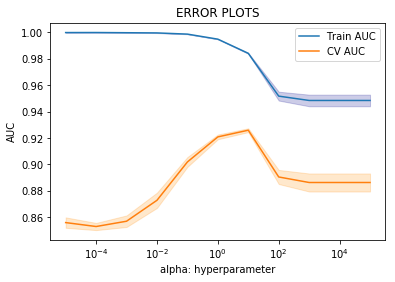

In [41]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(a, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [42]:
print(clf.best_estimator_)
print("Best score = ", clf.best_score_)
print("Best alpha = ", clf.best_params_)

SGDClassifier(alpha=10, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best score =  0.9258715549502432
Best alpha =  {'alpha': 10}


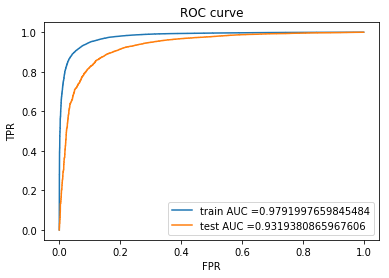

In [43]:
#training our model with the best optimal alpha, and find the AUC on test data and plot the ROC curve on both train and test.
# Set class_weight = 'balanced' on your LR models. This is will not allow the dominant class to get an unfair advantage.
SVM = SGDClassifier(loss='hinge', penalty='l2', alpha=10, class_weight = 'balanced')
LrSVM=CalibratedClassifierCV(SVM) #probability estimates are not available for loss='hinge',hence using "CalibratedClassifierCV"
LrSVM.fit(X_train_bow_S, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, LrSVM.predict_proba(X_train_bow_S)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LrSVM.predict_proba(X_test_bow_S)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

Train confusion matrix


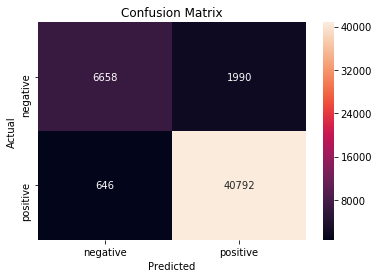

Test confusion matrix


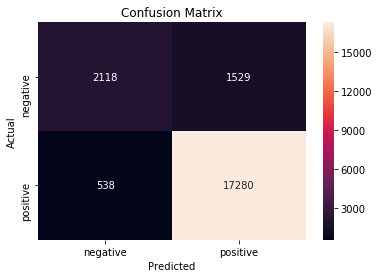

In [44]:
# Confusion matrix
print("Train confusion matrix")
matrix_train= confusion_matrix(y_train, LrSVM.predict(X_train_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train = pd.DataFrame(matrix_train,columns,index)
sns.heatmap(df_matrix_train, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test= confusion_matrix(y_test, LrSVM.predict(X_test_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test = pd.DataFrame(matrix_test,columns,index)
sns.heatmap(df_matrix_test, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

 ##### Top Feature Importance

In [45]:
# Top 10 positive features from BOW:
feature_name= count_vect.get_feature_names()
SVM.fit(X_train_bow_S,y_train)
W=SVM.coef_
positive_index=np.argsort(W)[:,::-1]
#negative_indx=np.argsort(weight)
print("Top 10 positive features from BOW:")
for i in (positive_index[0][0:10]):
    print(feature_name[i])

Top 10 positive features from BOW:
great
love
best
delicious
perfect
good
favorite
easy
highly
loves


In [46]:
# Top 10 negative features from BOW:
negative_index=np.argsort(W)
print("Top 10 negative features from BOW:")
for i in (negative_index[0][0:10]):
    print(feature_name[i])

Top 10 negative features from BOW:
disappointed
not
money
waste
worst
terrible
horrible
disappointing
awful
return


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [47]:
# Please write all the code with proper documentation
# Standadizing both X_TRAIN_tfidf AND X_TEST_tfidf
Standard1 = StandardScaler(with_mean=False).fit(X_train_tfidf) # Fitting the Standardizer only to train data to avoid data leakage.
X_train_tfidf_S = Standard1.transform(X_train_tfidf)
X_test_tfidf_S = Standard1.transform(X_test_tfidf)

In [48]:
# Using Grid search method to find the optimal alpha.
SGDClass= SGDClassifier(loss='hinge', penalty='l2', class_weight = 'balanced') # Using SGD classifier for linear kernel.
a = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here a is the hyperparameter
parameter= [{'alpha':a}]
clf1 = GridSearchCV(SGDClass, parameter, cv=3, scoring='roc_auc', return_train_score= True )
clf1= clf1.fit(X_train_tfidf_S, y_train)

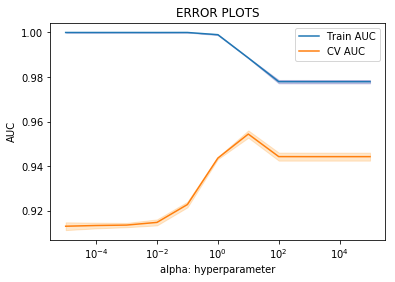

In [49]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum alpha.
train_auc1= clf1.cv_results_['mean_train_score']
train_auc_std1= clf1.cv_results_['std_train_score']
cv_auc1 = clf1.cv_results_['mean_test_score'] 
cv_auc_std1= clf1.cv_results_['std_test_score']

plt.semilogx(a, train_auc1, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc1 - train_auc_std1,train_auc1 + train_auc_std1,alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc1, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc1 - cv_auc_std1,cv_auc1 + cv_auc_std1,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [50]:
print(clf1.best_estimator_)
print("Best score = ", clf1.best_score_)
print("Best alpha = ", clf1.best_params_)

SGDClassifier(alpha=10, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best score =  0.9544062082313057
Best alpha =  {'alpha': 10}


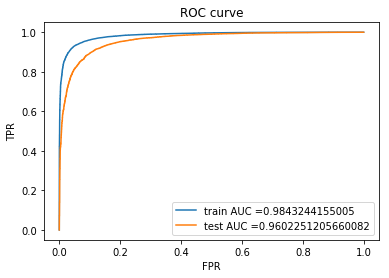

In [51]:
#training our model with the best optimal alpha, and find the AUC on test data and plot the ROC curve on both train and test.
# Set class_weight = 'balanced' on your LR models. This is will not allow the dominant class to get an unfair advantage.
SVM1 = SGDClassifier(loss='hinge', penalty='l2', alpha=10, class_weight = 'balanced')
LrSVM1=CalibratedClassifierCV(SVM1) #probability estimates are not available for loss='hinge',hence using "CalibratedClassifierCV"
LrSVM1.fit(X_train_tfidf_S, y_train)

train_fpr1, train_tpr1, thresholds1 = roc_curve(y_train, LrSVM1.predict_proba(X_train_tfidf_S)[:,1])
test_fpr1, test_tpr1, thresholds1 = roc_curve(y_test, LrSVM1.predict_proba(X_test_tfidf_S)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

Train confusion matrix


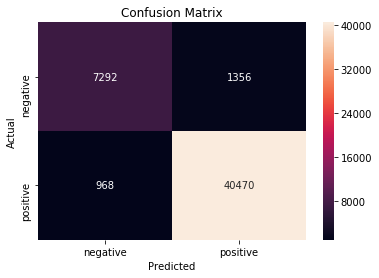

Test confusion matrix


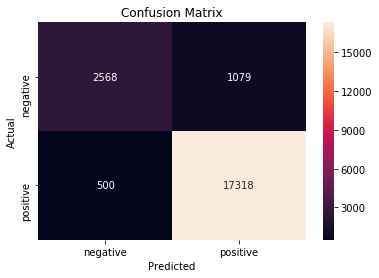

In [52]:
# Confusion matrix
print("Train confusion matrix")
matrix_train1= confusion_matrix(y_train, LrSVM1.predict(X_train_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train1 = pd.DataFrame(matrix_train1,columns,index)
sns.heatmap(df_matrix_train1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test1= confusion_matrix(y_test, LrSVM1.predict(X_test_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test1 = pd.DataFrame(matrix_test1,columns,index)
sns.heatmap(df_matrix_test1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

 ##### Top Feature Importance

In [53]:
# Top 10 positive features from tfidf:
feature_name1= tf_idf_vect.get_feature_names()
SVM1.fit(X_train_tfidf_S,y_train)
W1=SVM1.coef_
positive_index1=np.argsort(W1)[:,::-1]
#negative_indx=np.argsort(weight)
print("Top 10 positive features from BOW:")
for i in (positive_index1[0][0:10]):
    print(feature_name1[i])

Top 10 positive features from BOW:
great
love
best
delicious
good
perfect
favorite
nice
easy
loves


In [54]:
# Top 10 negative features from tfidf:
negative_index1=np.argsort(W1)
print("Top 10 negative features from BOW:")
for i in (negative_index1[0][0:10]):
    print(feature_name1[i])

Top 10 negative features from BOW:
not
disappointed
not buy
not recommend
would not
worst
not worth
bad
disappointing
terrible


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [55]:
# Please write all the code with proper documentation
# Standadizing both X_TRAIN_BOW AND X_TEST_BOW
Standard2 = StandardScaler(with_mean=False).fit(X_train_w2v) # Fitting the Standardizer only to train data to avoid data leakage.
X_train_w2v_S = Standard2.transform(X_train_w2v)
X_test_w2v_S = Standard2.transform(X_test_w2v)

In [56]:
# Using Grid search method to find the optimal alpha.
SGDClass= SGDClassifier(loss='hinge', penalty='l2', class_weight = 'balanced') # Using SGD classifier for linear kernel.
a = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here a is the hyperparameter
parameter= [{'alpha':a}]
clf2 = GridSearchCV(SGDClass, parameter, cv=3, scoring='roc_auc', return_train_score= True )
clf2= clf2.fit(X_train_w2v_S, y_train)

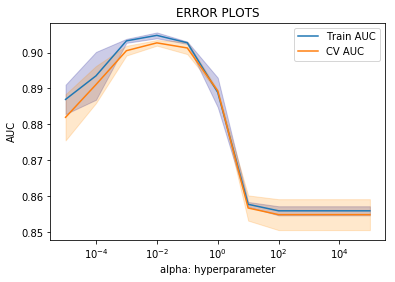

In [57]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum alpha.
train_auc2= clf2.cv_results_['mean_train_score']
train_auc_std2= clf2.cv_results_['std_train_score']
cv_auc2 = clf2.cv_results_['mean_test_score'] 
cv_auc_std2= clf2.cv_results_['std_test_score']

plt.semilogx(a, train_auc2, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc2 - train_auc_std2,train_auc2 + train_auc_std2,alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc2, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc2 - cv_auc_std2,cv_auc2 + cv_auc_std2,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [58]:
print(clf2.best_estimator_)
print("Best score = ", clf2.best_score_)
print("Best alpha = ", clf2.best_params_)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best score =  0.9026949080486324
Best alpha =  {'alpha': 0.01}


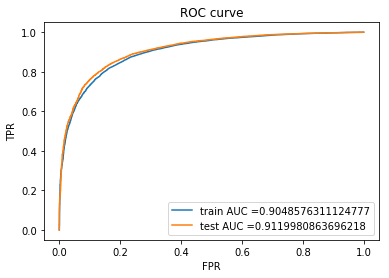

In [59]:
#training our model with the best optimal alpha, and find the AUC on test data and plot the ROC curve on both train and test.
# Set class_weight = 'balanced' on your LR models. This is will not allow the dominant class to get an unfair advantage.
SVM2 = SGDClassifier(loss='hinge', penalty='l2', alpha=0.01, class_weight = 'balanced')
LrSVM2=CalibratedClassifierCV(SVM2) #probability estimates are not available for loss='hinge',hence using "CalibratedClassifierCV"
LrSVM2.fit(X_train_w2v_S, y_train)

train_fpr2, train_tpr2, thresholds2 = roc_curve(y_train, LrSVM2.predict_proba(X_train_w2v_S)[:,1])
test_fpr2, test_tpr2, thresholds2 = roc_curve(y_test, LrSVM2.predict_proba(X_test_w2v_S)[:,1])

plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

Train confusion matrix


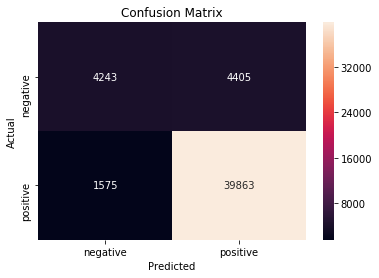

Test confusion matrix


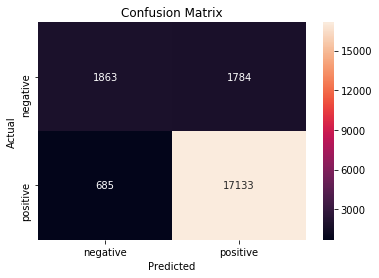

In [60]:
# Confusion matrix
print("Train confusion matrix")
matrix_train2= confusion_matrix(y_train, LrSVM2.predict(X_train_w2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train2 = pd.DataFrame(matrix_train2,columns,index)
sns.heatmap(df_matrix_train2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test2= confusion_matrix(y_test, LrSVM2.predict(X_test_w2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test2 = pd.DataFrame(matrix_test2,columns,index)
sns.heatmap(df_matrix_test2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [61]:
# Please write all the code with proper documentation
# Standadizing both X_TRAIN_BOW AND X_TEST_BOW
Standard3 = StandardScaler(with_mean=False).fit(X_train_tfidfw2v) # Fitting the Standardizer only to train data to avoid data leakage.
X_train_tfidfw2v_S = Standard3.transform(X_train_tfidfw2v)
X_test_tfidfw2v_S = Standard3.transform(X_test_tfidfw2v)

In [62]:
# Using Grid search method to find the optimal alpha.
SGDClass= SGDClassifier(loss='hinge', penalty='l2', class_weight = 'balanced') # Using SGD classifier for linear kernel.
a = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here a is the hyperparameter
parameter= [{'alpha':a}]
clf3 = GridSearchCV(SGDClass, parameter, cv=3, scoring='roc_auc', return_train_score= True )
clf3= clf3.fit(X_train_tfidfw2v_S, y_train)

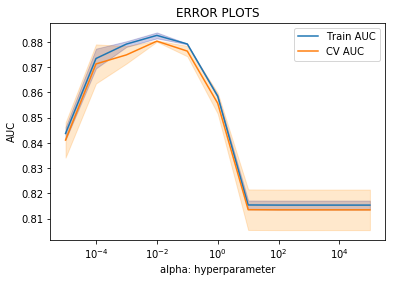

In [63]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum alpha.
train_auc3= clf3.cv_results_['mean_train_score']
train_auc_std3= clf3.cv_results_['std_train_score']
cv_auc3 = clf3.cv_results_['mean_test_score'] 
cv_auc_std3= clf3.cv_results_['std_test_score']

plt.semilogx(a, train_auc3, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc3 - train_auc_std3,train_auc3 + train_auc_std3,alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc3, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc3 - cv_auc_std3, cv_auc3 + cv_auc_std3, alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [64]:
print(clf3.best_estimator_)
print("Best score = ", clf3.best_score_)
print("Best alpha = ", clf3.best_params_)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best score =  0.8803193170895608
Best alpha =  {'alpha': 0.01}


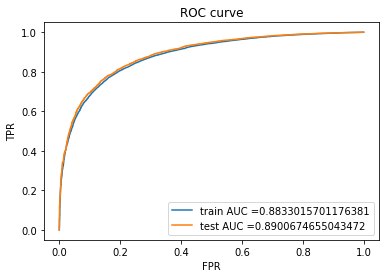

In [65]:
#training our model with the best optimal alpha, and find the AUC on test data and plot the ROC curve on both train and test.
# Set class_weight = 'balanced' on your LR models. This is will not allow the dominant class to get an unfair advantage.
SVM3 = SGDClassifier(loss='hinge', penalty='l2', alpha=0.01, class_weight = 'balanced')
LrSVM3=CalibratedClassifierCV(SVM3) #probability estimates are not available for loss='hinge',hence using "CalibratedClassifierCV"
LrSVM3.fit(X_train_tfidfw2v_S, y_train)


train_fpr3, train_tpr3, thresholds3 = roc_curve(y_train, LrSVM3.predict_proba(X_train_tfidfw2v_S)[:,1])
test_fpr3, test_tpr3, thresholds3 = roc_curve(y_test, LrSVM3.predict_proba(X_test_tfidfw2v_S)[:,1])

plt.plot(train_fpr3, train_tpr3, label="train AUC ="+str(auc(train_fpr3, train_tpr3)))
plt.plot(test_fpr3, test_tpr3, label="test AUC ="+str(auc(test_fpr3, test_tpr3)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

Train confusion matrix


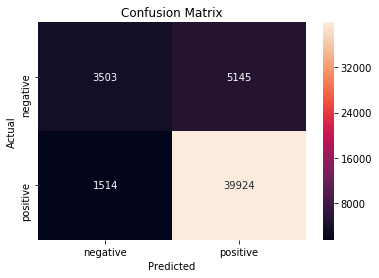

Test confusion matrix


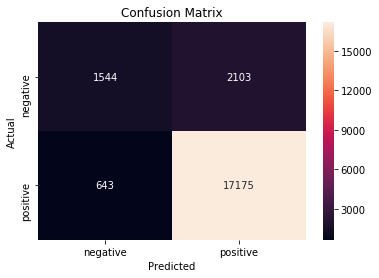

In [66]:
# Confusion matrix
print("Train confusion matrix")
matrix_train3= confusion_matrix(y_train, LrSVM3.predict(X_train_tfidfw2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train3 = pd.DataFrame(matrix_train3,columns,index)
sns.heatmap(df_matrix_train3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test3= confusion_matrix(y_test, LrSVM3.predict(X_test_tfidfw2v_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test3 = pd.DataFrame(matrix_test3,columns,index)
sns.heatmap(df_matrix_test3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Feature engineering:

In [67]:
# Finding the lenght of the review:
Review_len = [len(sentence.split()) for sentence in preprocessed_reviews]

In [68]:
Review_len[1500]

20

In [69]:
preprocessed_reviews[1500]

'bought green product however trouble worth hard scoop needs frequent changing tracks worse around house nothing control cat smell issue'

In [70]:
#Adding review length and summary to preprocessed_review as the part of Feature engineering:
preprocessed_reviews1= []
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]+=' '+preprocessed_summary[i]+' '+str(Review_len[i])
    preprocessed_reviews1.append(preprocessed_reviews[i])

In [71]:
preprocessed_reviews1[1500]

'bought green product however trouble worth hard scoop needs frequent changing tracks worse around house nothing control cat smell issue bad product 20'

In [72]:
X1= preprocessed_reviews1
Y1 = Score

In [73]:
# Slicing the Data X and Y into X_train, X_test, y_train and y_test in the ratio 70:30
# making sure not to use train_test_split as it would randomly split points and disturb the sorting
X1_train= X1[0:50086]
X1_test= X1[50086:]
y1_train= Y1[0:50086]
y1_test= Y1[50086:]

### [5.2.1]  FE: Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [74]:
# Please write all the code with proper documentation
#BoW
count_vect1 = CountVectorizer()
count_vect1.fit(X1_train) # fit has to happen only on train data

X_train_fe_bow = count_vect1.transform(X1_train)
X_test_fe_bow = count_vect1.transform(X1_test)

print("the type of count vectorizer ",type(X_train_fe_bow))
print("the number of unique words in X_train_fe",X_train_fe_bow.shape[1])
print('='*50)
print("After vectorizations")
print(X_train_fe_bow.shape, y1_train.shape)
print(X_test_fe_bow.shape, y1_test.shape)
print("="*50)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in X_train_fe 44869
After vectorizations
(50086, 44869) (50086,)
(21465, 44869) (21465,)


In [75]:
# Standardizing both X_TRAIN_fe_BOW AND X_TEST_fe_BOW
Standard4= StandardScaler(with_mean=False).fit(X_train_fe_bow)
X_train_fe_bow_S = Standard4.transform(X_train_fe_bow)
X_test_fe_bow_S = Standard4.transform(X_test_fe_bow)

In [76]:
SGDClass= SGDClassifier(loss='hinge', penalty='l2', class_weight = 'balanced') # Using SGD classifier for linear kernel.
a = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here a is the hyperparameter
parameter= [{'alpha':a}]
clf4 = GridSearchCV(SGDClass, parameter, cv=3, scoring='roc_auc', return_train_score= True )
clf4= clf4.fit(X_train_fe_bow_S, y1_train)

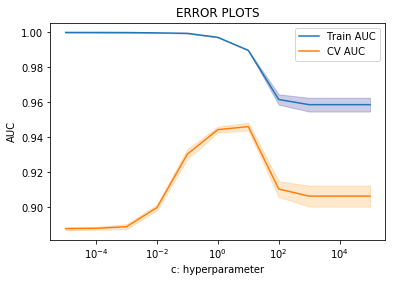

In [77]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum alpha.
train_auc4= clf4.cv_results_['mean_train_score']
train_auc_std4= clf4.cv_results_['std_train_score']
cv_auc4 = clf4.cv_results_['mean_test_score'] 
cv_auc_std4= clf4.cv_results_['std_test_score']

plt.semilogx(a, train_auc4, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc4 - train_auc_std4,train_auc4 + train_auc_std4,alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc4, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc4 - cv_auc_std4,cv_auc4 + cv_auc_std4,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [78]:
print(clf4.best_estimator_)
print("Best score = ", clf4.best_score_)
print("Best alpha = ", clf4.best_params_)

SGDClassifier(alpha=10, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best score =  0.9460391481488855
Best alpha =  {'alpha': 10}


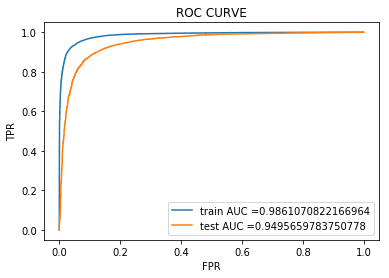

In [79]:
#training our model with the best optimal alpha, and find the AUC on test data and plot the ROC curve on both train and test.
# Set class_weight = 'balanced' on your LR models. This is will not allow the dominant class to get an unfair advantage.
SVM4 = SGDClassifier(loss='hinge', penalty='l2', alpha=10, class_weight = 'balanced')
LrSVM4=CalibratedClassifierCV(SVM4) #probability estimates are not available for loss='hinge',hence using "CalibratedClassifierCV"
LrSVM4.fit(X_train_fe_bow_S, y1_train)

train_fpr4, train_tpr4, thresholds4 = roc_curve(y1_train, LrSVM4.predict_proba(X_train_fe_bow_S)[:,1])
test_fpr4, test_tpr4, thresholds4 = roc_curve(y1_test, LrSVM4.predict_proba(X_test_fe_bow_S)[:,1])

plt.plot(train_fpr4, train_tpr4, label="train AUC ="+str(auc(train_fpr4, train_tpr4)))
plt.plot(test_fpr4, test_tpr4, label="test AUC ="+str(auc(test_fpr4, test_tpr4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


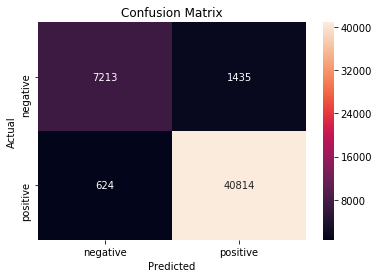

Test confusion matrix


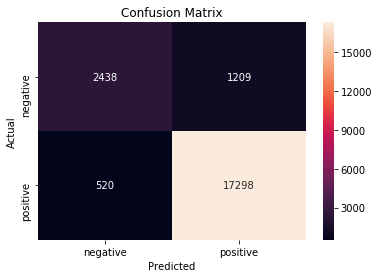

In [80]:
# Confusion matrix
print("Train confusion matrix")
matrix_train4= confusion_matrix(y1_train, LrSVM4.predict(X_train_fe_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train4 = pd.DataFrame(matrix_train4,columns,index)
sns.heatmap(df_matrix_train4, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test4= confusion_matrix(y1_test, LrSVM4.predict(X_test_fe_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test4 = pd.DataFrame(matrix_test4,columns,index)
sns.heatmap(df_matrix_test4, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.2.2] FE: Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [81]:
# Please write all the code with proper documentation
#tfidf
tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect1.fit(X1_train)
print('='*50)

X_train_fe_tfidf = tf_idf_vect1.transform(X1_train)
X_test_fe_tfidf = tf_idf_vect1.transform(X1_test)
print("the type of tf_idf_vect1",type(X_train_fe_tfidf))
print('='*50)

print("After vectorizations")
print(X_train_fe_tfidf.shape, y1_train.shape)
print(X_test_fe_tfidf.shape, y1_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect1 of X_train_fe ", X_train_fe_tfidf.shape[1])

the type of tf_idf_vect1 <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(50086, 32685) (50086,)
(21465, 32685) (21465,)
The number of unique words in tf_idf_vect1 of X_train_fe  32685


In [82]:
# Standardizing both X_TRAIN_BOW AND X_TEST_BOW
Standard5= StandardScaler(with_mean=False).fit(X_train_fe_tfidf)
X_train_fe_tfidf_S = Standard5.transform(X_train_fe_tfidf)
X_test_fe_tfidf_S = Standard5.transform(X_test_fe_tfidf)

In [83]:
SGDClass= SGDClassifier(loss='hinge', penalty='l2', class_weight = 'balanced') # Using SGD classifier for linear kernel.
a = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
# Here a is the hyperparameter
parameter= [{'alpha':a}]
clf5= GridSearchCV(SGDClass, parameter, cv=3, scoring='roc_auc', return_train_score= True )
clf5= clf5.fit(X_train_fe_tfidf_S, y1_train)

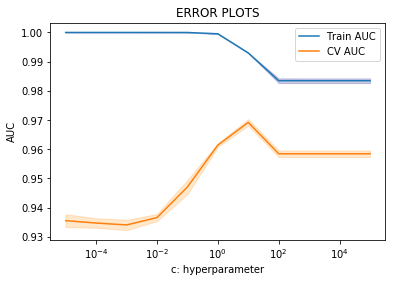

In [84]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum alpha.
train_auc5= clf5.cv_results_['mean_train_score']
train_auc_std5= clf5.cv_results_['std_train_score']
cv_auc5 = clf5.cv_results_['mean_test_score'] 
cv_auc_std5= clf5.cv_results_['std_test_score']

plt.semilogx(a, train_auc5, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc5 - train_auc_std5, train_auc5 + train_auc_std5, alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc5, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc5 - cv_auc_std5, cv_auc5 + cv_auc_std5, alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("c: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [85]:
print(clf5.best_estimator_)
print("Best score = ", clf5.best_score_)
print("Best alpha = ", clf5.best_params_)

SGDClassifier(alpha=10, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best score =  0.9691907220825982
Best alpha =  {'alpha': 10}


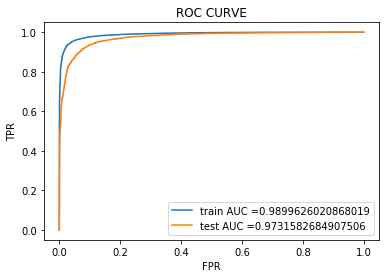

In [86]:
#training our model with the best optimal alpha, and find the AUC on test data and plot the ROC curve on both train and test.
# Set class_weight = 'balanced' on your LR models. This is will not allow the dominant class to get an unfair advantage.
SVM5 = SGDClassifier(loss='hinge', penalty='l2', alpha=10, class_weight = 'balanced')
LrSVM5=CalibratedClassifierCV(SVM5) #probability estimates are not available for loss='hinge',hence using "CalibratedClassifierCV"
LrSVM5.fit(X_train_fe_tfidf_S, y1_train)

train_fpr5, train_tpr5, thresholds5 = roc_curve(y1_train, LrSVM5.predict_proba(X_train_fe_tfidf_S)[:,1])
test_fpr5, test_tpr5, thresholds5 = roc_curve(y1_test, LrSVM5.predict_proba(X_test_fe_tfidf_S)[:,1])

plt.plot(train_fpr5, train_tpr5, label="train AUC ="+str(auc(train_fpr5, train_tpr5)))
plt.plot(test_fpr5, test_tpr5, label="test AUC ="+str(auc(test_fpr5, test_tpr5)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


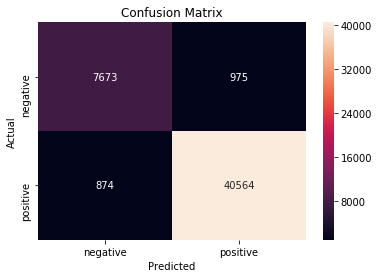

Test confusion matrix


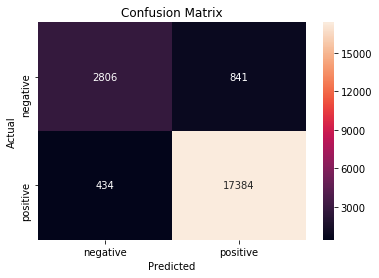

In [87]:
# Confusion matrix
print("Train confusion matrix")
matrix_train5= confusion_matrix(y1_train, LrSVM5.predict(X_train_fe_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train5 = pd.DataFrame(matrix_train5,columns,index)
sns.heatmap(df_matrix_train5, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test5= confusion_matrix(y1_test, LrSVM5.predict(X_test_fe_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test5 = pd.DataFrame(matrix_test5,columns,index)
sns.heatmap(df_matrix_test5, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Please find the Analysis RBF SVM in the Next Doc

#### Reference:
- www.appliedaicourse.com
- https://stackoverflow.com